#### Summary of data cleaning for statistical analysis<br>


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from numpy.random import seed
from scipy.stats import gamma, poisson
from scipy.stats import norm
from numpy.random import seed

import pymc3 as pm
from scipy.stats import gamma

import arviz as az

<b> Load files and visually compare - they should be identical</b>

In [103]:
  # Read data into files
classify = pd.read_csv('weka2c.csv')
category = pd.read_csv('weka3c.csv')

In [104]:
#  Merge the files and rename the columns
df = pd.merge(category, classify, on='degree_spondylolisthesis', how='right')
df2 = df[['pelvic_incidence_x', 'pelvic_tilt', 'lumbar_lordosis_angle_x', 'sacral_slope_x', 'pelvic_radius_x', 'degree_spondylolisthesis','class_x','class_y']]
df = df2.rename(columns = {'pelvic_incidence_x':'incidence', 'pelvic_tilt': 'tilt', 'lumbar_lordosis_angle_x': 'angle', 'sacral_slope_x': 'slope', 'pelvic_radius_x': 'radius', 'degree_spondylolisthesis' : 'degree', 'class_x' : 'category', 'class_y':'class'})
print(df.count(axis='rows'))

incidence    310
tilt         310
angle        310
slope        310
radius       310
degree       310
category     310
class        310
dtype: int64


In [105]:
# remove the ouliers, values > 360
df = df.loc[df['degree'] <= 360].copy(deep=True)

<b> Below we can look at Pearson's correlations betwen features.  There are a few that have similar plots and seem like promising positive correlations such as incidence and slope, incidence and angle.  

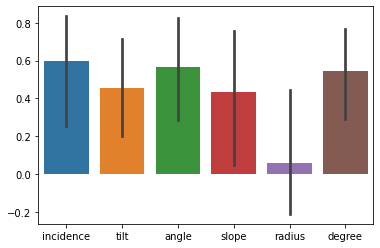

In [106]:
# Bar Chart of correlations between features
correlate = df.corr()
ax = sns.barplot(data=correlate)

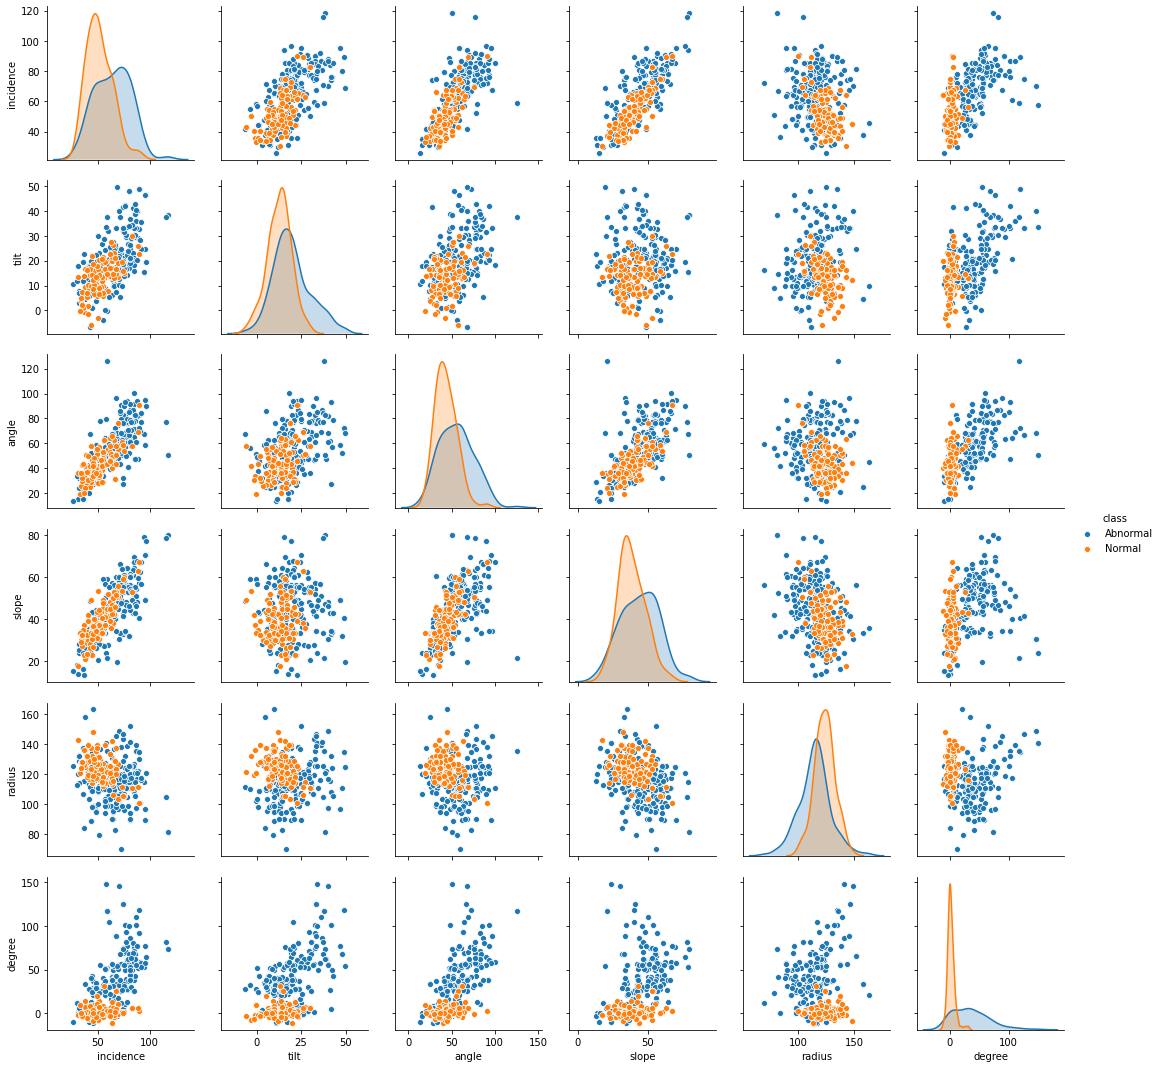

In [107]:
# Look at the correlations between features with Pearson's correlations plotted in a matrix
sns.pairplot(df, hue="class")
plt.show()

<b> The Pearson matrix below helps to select the best features to run a couple inference tests.  We see that the highest level of correlation is with slope and incidence.  It might be usefull to determine if radius is even necessary to include in the models, we'll also run a ttest on the strongest correlation, radius and slope, which is negatively correlated, meaning as one increases the other decreases.

In [108]:
print(df.corr())

           incidence      tilt     angle     slope    radius    degree
incidence   1.000000  0.659553  0.739510  0.804772 -0.244163  0.642157
tilt        0.659553  1.000000  0.432809  0.084618  0.030461  0.534300
angle       0.739510  0.432809  1.000000  0.638521 -0.080903  0.672138
slope       0.804772  0.084618  0.638521  1.000000 -0.347722  0.429320
radius     -0.244163  0.030461 -0.080903 -0.347722  1.000000 -0.000023
degree      0.642157  0.534300  0.672138  0.429320 -0.000023  1.000000


In [109]:
print(df[df["class"]== "Abnormal"].corr())

           incidence      tilt     angle     slope    radius    degree
incidence   1.000000  0.611463  0.710469  0.789207 -0.077448  0.632854
tilt        0.611463  1.000000  0.380307 -0.003372  0.243625  0.486118
angle       0.710469  0.380307  1.000000  0.602709  0.067936  0.675182
slope       0.789207 -0.003372  0.602709  1.000000 -0.286961  0.422499
radius     -0.077448  0.243625  0.067936 -0.286961  1.000000  0.223524
degree      0.632854  0.486118  0.675182  0.422499  0.223524  1.000000


In [110]:
print(df[df["class"]== "Normal"].corr())

           incidence      tilt     angle     slope    radius    degree
incidence   1.000000  0.633952  0.701138  0.838623 -0.490306  0.200249
tilt        0.633952  1.000000  0.302674  0.110382 -0.346577  0.181816
angle       0.701138  0.302674  1.000000  0.687876 -0.247364  0.260790
slope       0.838623  0.110382  0.687876  1.000000 -0.386005  0.129288
radius     -0.490306 -0.346577 -0.247364 -0.386005  1.000000 -0.058179
degree      0.200249  0.181816  0.260790  0.129288 -0.058179  1.000000


In [111]:
  # Slice data for ttest
incidence = df["incidence"]
slope = df["slope"]
radius = df["radius"]

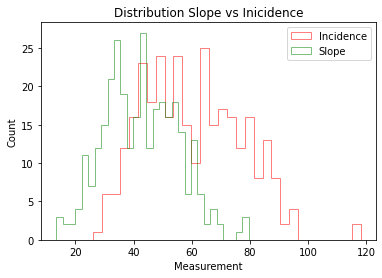

In [112]:
  # Distribution of incidence & slope
_ = plt.hist(incidence, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Incidence')
_ = plt.hist(slope, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Slope')
_ = plt.title("Distribution Slope vs Inicidence")
_ = plt.xlabel("Measurement")
_ = plt.ylabel("Count")
_ = plt.legend()

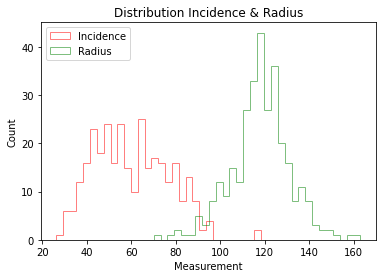

In [113]:
# Distribution of incidence vs radius
_ = plt.hist(incidence, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Incidence')
_ = plt.hist(radius, histtype = 'step', bins=30, alpha = 0.5, color ='green', label = 'Radius')
_ = plt.title("Distribution Incidence & Radius")
_ = plt.xlabel("Measurement")
_ = plt.ylabel("Count")
_ = plt.legend()

<b> So we see the two correlations we've selected have similar shapes.  Interesting.  Looking at the normal and abnormal data below brings into quesiton if the correlations are strong enough to classify.  We'll perform some bootstrapping and ttest the following hypothesis:  Abnormal and Normal results are correlalted to both normal and abnormal data. 

In [114]:
# slice"abnormal" data
abnormal = df.loc[df['class'] == 'Abnormal']['slope']
normal = df.loc[df['class'] == 'Normal']['slope']

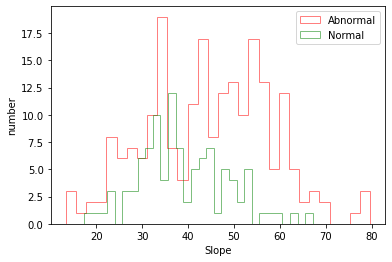

In [115]:

_ = plt.hist(abnormal, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'Abnormal')
_ = plt.hist(normal, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'Normal')
_ = plt.xlabel("Slope")
_ = plt.ylabel("number")
_ = plt.legend()

(array([ 6., 16., 23., 30., 36., 35., 35., 19.,  5.,  4.]),
 array([13.3669307 , 19.99975298, 26.63257527, 33.26539755, 39.89821983,
        46.53104211, 53.1638644 , 59.79668668, 66.42950896, 73.06233125,
        79.69515353]),
 [<matplotlib.patches.Polygon at 0x1dbf8690e88>])

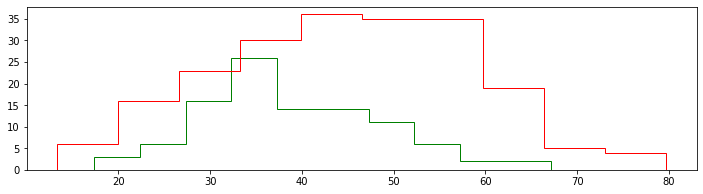

In [116]:
plt.figure(figsize=[12,3])
plt.hist(normal, histtype='step', color = 'green')
plt.hist(abnormal, histtype='step', color = 'red')

<b> This looks like a gamma distribution.  Using bootstrapping techniques we can test the hypothesis that states: The Normal and Abnormal data are correlated. <br> 

#### Analysis <br>


In [117]:
  # Priors for random sample generation
std_abnormal = np.std(abnormal)
mn_abnormal = np.mean(abnormal)

In [118]:
  # Priors for random sample generation
std_abnormal = np.std(normal)
mn_abnormal = np.mean(normal)

In [119]:
  # Generate random numbers using the Gamma Distribution to represent the abnomral data
ab_alpha_est = np.mean(abnormal)**2 / np.var(abnormal)
ab_beta_est = np.var(abnormal) / np.mean(abnormal)
alpha_est, beta_est

(0.12138925474780451, 18.012896329685613)

In [120]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est

In [121]:
with pm.Model() as model_no_ins:
    
    # Priors for unknown model parameters
    alpha_ = pm.Exponential("alpha", 1/alpha_est)
    rate_ = pm.Exponential("beta", 1/rate_est)

    # Likelihood (sampling distribution) of observations
    normal_vals = pm.Gamma("normal", alpha=alpha_, beta=rate_, observed=normal)

    # draw 10000 posterior samples
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
The acceptance probability does not match the target. It is 0.8832537604786582, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [131]:
with pm.Model() as model_no_ins:
    
    # Priors for unknown model parameters
    mean = np.mean(normal)
    std = np.std(normal)

    # Likelihood (sampling distribution) of observations
    normal_vals = pm.Normal("values",mean, std)

    # draw 10000 posterior samples
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [values]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [132]:
#Calculate the 95 perceent interval for alpha and beta
Confidence_a = np.percentile(trace.alpha,[2.5,97.5])
Confidence_b = 1/np.percentile(trace.beta,[2.5,97.5])

AttributeError: 'MultiTrace' object has no attribute 'alpha'

In [134]:
#Calculate the 95 perceent interval for alpha and beta
Confidence_a = np.percentile(trace.values,[2.5,97.5])

In [135]:
print('Alpha 95% Confidence Interval: ', Confidence_a)
print('Beta 95% Confidence Interval: ', Confidence_b)

Alpha 95% Confidence Interval:  [19.47711127 57.63576334]
Beta 95% Confidence Interval:  [11.52612209  6.6964156 ]


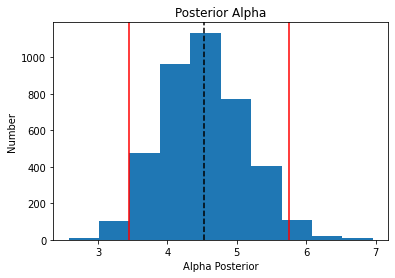

In [124]:
#Plot your posterior values of alpha - histogram
_= plt.hist(trace.alpha)
_= plt.axvline(np.mean(trace.alpha), color = 'black', linestyle = "--")
_= plt.axvline(np.percentile(trace.alpha,2.5), color = 'red')
_= plt.axvline(np.percentile(trace.alpha,97.5), color = 'red')
_= plt.xlabel('Alpha Posterior')
_= plt.ylabel('Number')
_= plt.title('Posterior Alpha')

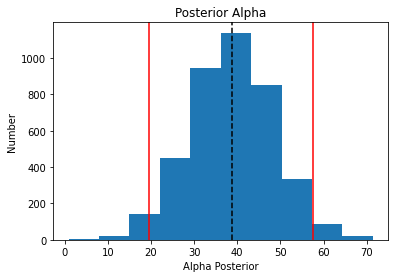

In [136]:
#Plot your posterior values of alpha - histogram
_= plt.hist(trace.values)
_= plt.axvline(np.mean(trace.values), color = 'black', linestyle = "--")
_= plt.axvline(np.percentile(trace.values,2.5), color = 'red')
_= plt.axvline(np.percentile(trace.values,97.5), color = 'red')
_= plt.xlabel('Alpha Posterior')
_= plt.ylabel('Number')
_= plt.title('Posterior Alpha')

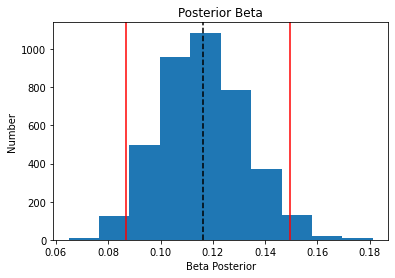

In [125]:
#Plot your posterior values of beta - histogram
_= plt.hist(trace.beta)
_= plt.axvline(np.mean(trace.beta), color = 'black', linestyle = "--")
_= plt.axvline(np.percentile(trace.beta,2.5), color = 'red')
_= plt.axvline(np.percentile(trace.beta,97.5), color = 'red')
_= plt.xlabel('Beta Posterior')
_= plt.ylabel('Number')
_= plt.title('Posterior Beta')

In [137]:
seed(47)
best_shot_simulated = gamma(trace.values.mean(), scale=1/trace.values.mean()).rvs(len(normal))

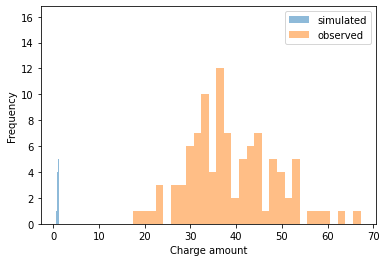

In [138]:
_ = plt.hist(best_shot_simulated, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(normal, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

In [80]:
  # Generate random numbers using the Gamma Distribution to represent the abnomral data
ab_alpha_est = np.mean(abnormal)**2 / np.var(abnormal)
ab_beta_est = np.var(abnormal) / np.mean(abnormal)
alpha_est, beta_est

(32.8240409649472, 438.6823139512466)

In [86]:
  # Generate random numbers using the Gamma Distribution to represent the abnomral data
alpha_est = np.mean(normal)**2 / np.var(normal)
beta_est = np.var(normal) / np.mean(normal)
alpha_est, beta_est

(0.12138925474780451, 18.012896329685613)

In [87]:
seed(47)
abnor_rvs = gamma(ab_alpha_est, scale=ab_beta_est).rvs(len(abnormal))

In [88]:
seed(47)
nor_rvs = gamma(alpha_est, scale=beta_est).rvs(len(normal))

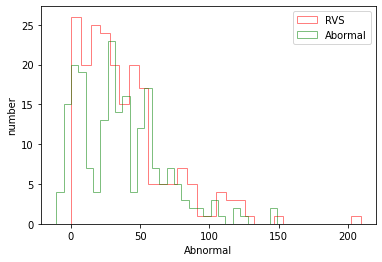

In [89]:
# The plot of abnormal results
_ = plt.hist(abnor_rvs, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'RVS')
_ = plt.hist(abnormal, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'Abormal')
_ = plt.xlabel("Abnormal")
_ = plt.ylabel("number")
_ = plt.legend()

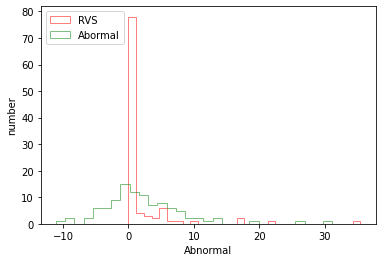

In [90]:
# The plot of abnormal results
_ = plt.hist(nor_rvs, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'RVS')
_ = plt.hist(normal, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'Abormal')
_ = plt.xlabel("Abnormal")
_ = plt.ylabel("number")
_ = plt.legend()

<b> Not good, lets try a normal distribution instead

In [91]:
mn_normal = np.mean(normal)
std_normal = np.std(normal)
norm_rvs = norm.rvs(mn_normal,std_normal, size=len(normal))

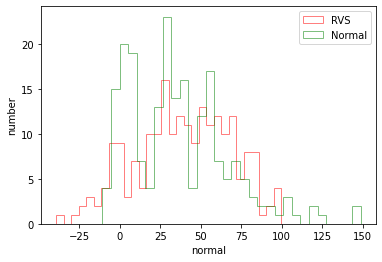

In [95]:

# The plot of abnormal results
_ = plt.hist(norm_rvs, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'RVS')
_ = plt.hist(abnormal, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'Normal')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

In [21]:
# slice"abnormal" data
classified = df.loc[df['class'] == 'Abnormal']['degree']
hernia = df.loc[df['category'] == 'Hernia']['degree']
spondylolisthesis = df.loc[df['category'] == 'Spondylolisthesis']['degree']

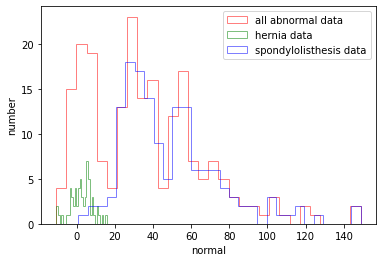

In [22]:
# The plot of abnormal results
_ = plt.hist(classified, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'all abnormal data')
_ = plt.hist(hernia, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'hernia data')
_ = plt.hist(spondylolisthesis, histtype = 'step', bins=30, alpha=0.5, color ='blue', label = 'spondylolisthesis data')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

In [12]:
# slice"abnormal" data
classified = df.loc[df['class'] == 'Abnormal']['slope']
hernia = df.loc[df['category'] == 'Hernia']['slope']
spondylolisthesis = df.loc[df['category'] == 'Spondylolisthesis']['slope']

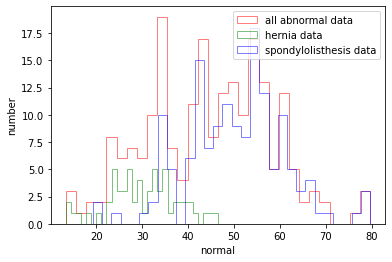

In [13]:
# The plot of abnormal results
_ = plt.hist(classified, histtype = 'step', bins=30, alpha = 0.5, color = 'red', label = 'all abnormal data')
_ = plt.hist(hernia, histtype = 'step', bins=30, alpha=0.5, color ='green', label = 'hernia data')
_ = plt.hist(spondylolisthesis, histtype = 'step', bins=30, alpha=0.5, color ='blue', label = 'spondylolisthesis data')
_ = plt.xlabel("normal")
_ = plt.ylabel("number")
_ = plt.legend()

<b> Below we see that any degree of spondylolithesis greater than 30 is automatically an abnormal result.<br>  Also we see the normal results are distributed normally around the 0 value, while abnormal results are shaped more exponentially leaning right.</b>

(array([39., 30., 50., 32., 29., 15.,  5.,  4.,  3.,  2.]),
 array([-10.67587083,   5.26708734,  21.21004552,  37.15300369,
         53.09596186,  69.03892004,  84.98187821, 100.92483638,
        116.86779455, 132.81075273, 148.7537109 ]),
 [<matplotlib.patches.Polygon at 0x1fd3a0cca88>])

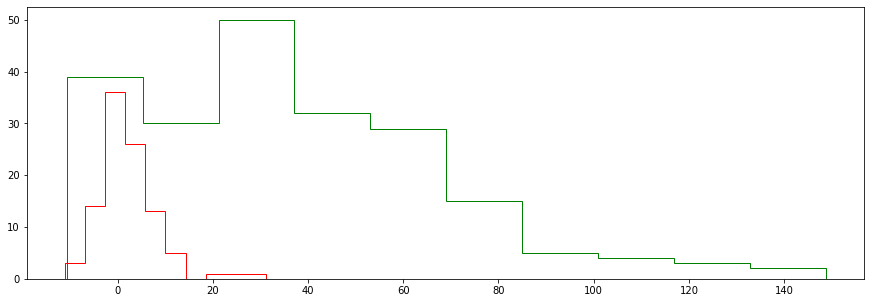

In [10]:
normal = df[df['class'] == 'Normal']['degree']
abnormal = df[df['class'] == 'Abnormal']['degree']

plt.figure(figsize=[15,5])
plt.hist(normal, histtype='step', color = 'red')
plt.hist(abnormal, histtype='step', color = 'green')

In [117]:
df['class']=df['class'].map({'Normal':0,'Abnormal':1})

In [13]:
print(df[df["class"]== "Normal"].corr())

           incidence      tilt     angle     slope    radius    degree
incidence   1.000000  0.633952  0.701138  0.838623 -0.490306  0.200249
tilt        0.633952  1.000000  0.302674  0.110382 -0.346577  0.181816
angle       0.701138  0.302674  1.000000  0.687876 -0.247364  0.260790
slope       0.838623  0.110382  0.687876  1.000000 -0.386005  0.129288
radius     -0.490306 -0.346577 -0.247364 -0.386005  1.000000 -0.058179
degree      0.200249  0.181816  0.260790  0.129288 -0.058179  1.000000


In [14]:
print(df[df["class"]== "Abnormal"].corr())

           incidence      tilt     angle     slope    radius    degree
incidence   1.000000  0.611463  0.710469  0.789207 -0.077448  0.632854
tilt        0.611463  1.000000  0.380307 -0.003372  0.243625  0.486118
angle       0.710469  0.380307  1.000000  0.602709  0.067936  0.675182
slope       0.789207 -0.003372  0.602709  1.000000 -0.286961  0.422499
radius     -0.077448  0.243625  0.067936 -0.286961  1.000000  0.223524
degree      0.632854  0.486118  0.675182  0.422499  0.223524  1.000000


<b> Interesting comparison between the Abnormal correlation set and the full dataset correlation with a marked increase in pelvic radius being correlated. <BR>  What I find interesting about this is the potential to weight the radius as more important that we might have initially thought.  If we do a weighted analysis these comparisons would be important.

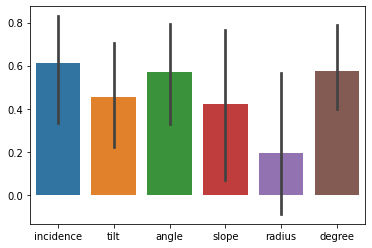

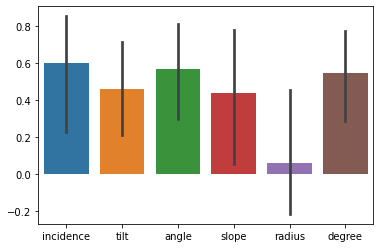

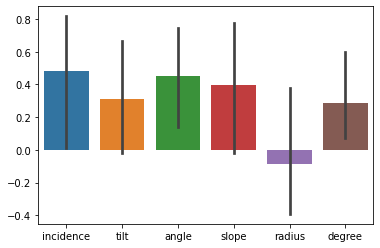

<b> Statistical inference analysis.  <br> Below we can attempt to use a Baysian statistical analysis.  Although, from the distribution we can see to acheive better accuracy would require separation of the 2 sets of data that appear independent within the abnormal, heria and spondylolisthesis.  The hearniated data is normally distributed whie the spondylolisthesis is exponentially.  To attempt to get accuracy with 2 different data sets combined will not be acceptable.

In [29]:
abn = df[(df['class'] == 'Abnormal')]
nor = df[(df['class'] == 'Normal')]
abn = abn["degree"]
nor = nor["degree"]
n_abn = len(abn)
n_nor = len(nor)

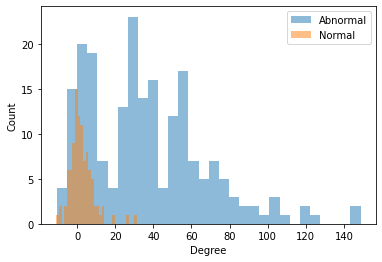

In [30]:
_ = plt.hist(abn, bins=30, alpha=0.5, label='Abnormal')
_ = plt.hist(nor, bins=30, alpha=0.5, label='Normal')
_ = plt.xlabel('Degree')
_ = plt.ylabel('Count')
_ = plt.legend()

In [31]:
alpha_est = np.mean(abn)**2 / np.var(abn)
beta_est = np.var(abn) / np.mean(abn)
alpha_est, beta_est

(1.347800055346333, 26.67744450790181)

In [32]:
seed(47)
abn_rvs = gamma(alpha_est, scale=beta_est).rvs(n_abn)

<b> The graph below shows the orinial abnormal data compared to the random variates using an exponential scale

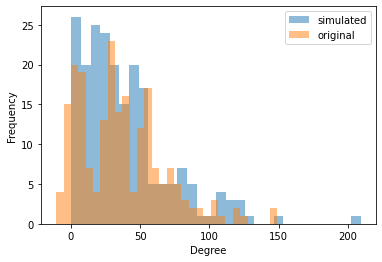

In [33]:
_ = plt.hist(abn_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(abn, bins=30, alpha=0.5, label='original')
_ = plt.xlabel('Degree')
_ = plt.ylabel('Frequency')
_ = plt.legend()

<b> Running a ttest comparing all the features correlation we have a positive correlation between the following features: <br>  Degree & Slope, 

In [205]:
aabn = df[(df['degree'] != 0)]
gabn = aabn["angle"].copy()
iabn = aabn["incidence"].copy()
sabn = aabn["slope"].copy()
dabn = aabn["degree"].copy()
rabn = aabn["radius"].copy()

In [206]:
     #importing ttest_ind gives similar results
from scipy.stats import ttest_ind
print( "Angle ttest results: ")
ttest_ind(abn,gabn)

Angle ttest results: 


Ttest_indResult(statistic=-7.3200393192681625, pvalue=9.56877757260715e-13)

In [207]:
print( "Incidence ttest results: ")
ttest_ind(abn,iabn)

Incidence ttest results: 


Ttest_indResult(statistic=-11.503413547267273, pvalue=2.0311651666544504e-27)

In [209]:
print( "Slope ttest results: ")
ttest_ind(abn,sabn)

Slope ttest results: 


Ttest_indResult(statistic=-3.421246012204748, pvalue=0.000672789356283565)

In [210]:
print( "Degree ttest results: ")
ttest_ind(abn,dabn)

Degree ttest results: 


Ttest_indResult(statistic=3.992484266668348, pvalue=7.487381678511185e-05)

In [211]:
print( "Radius ttest results: ")
ttest_ind(abn,rabn)

Radius ttest results: 


Ttest_indResult(statistic=-41.17168502461475, pvalue=3.6068534902310904e-165)

In [228]:
ttest_ind(rabn,sabn)

Ttest_indResult(statistic=71.92205188974408, pvalue=7.003822315658046e-302)

<b> Testing against angle

In [226]:
     #Angle vs Incidence
print( "Angle ttest results: ")
ttest_ind(iabn,gabn)

Angle ttest results: 


Ttest_indResult(statistic=5.844256195986752, pvalue=8.25037724106446e-09)

In [227]:
  #Angle vs Slope
ttest_ind(sabn,gabn)

Ttest_indResult(statistic=-7.222382237431311, pvalue=1.5132467067356786e-12)

In [ ]:
  #angle vs Incidence
ttest_ind(iabn,gabn)

In [220]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [223]:
x, y = ecdf(abn)
t, u = ecdf(aabn)

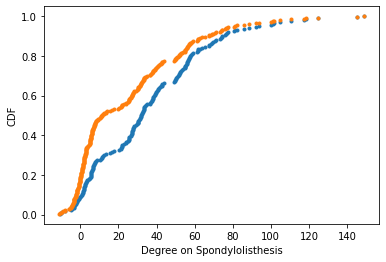

In [229]:
# Plot the CDF with axis labels
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.plot(t, u, marker='.', linestyle='none')
_ = plt.xlabel('Degree on Spondylolisthesis')
_ = plt.ylabel('CDF')

# Show the plot
plt.show()